In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors
import importlib
import networkx as nx
from adjustText import adjust_text

In [4]:
path = '/Users/hs0424/Workspace/copulacci/data/slide_seq_mouse_embryo/'
df_processed = pd.read_csv(path + 'SSembryo_RCTD.csv', header=0)

# Add abbreviation of cell typs to df_processed.
df_abbrev = pd.read_csv(path + 'SSembryo_abbrev.csv', header=0)

In [6]:
for i in range(len(df_processed)):

    ct1 = df_processed['first_type'][i]
    ct2 = df_processed['second_type'][i]
    for j in range(len(df_abbrev)):

        if ct1 == df_abbrev['Cluster'][j]:
            df_processed['celltype1'][i] = df_abbrev['Abbrev'][j]

        if ct2 == df_abbrev['Cluster'][j]:
            df_processed['celltype2'][i] = df_abbrev['Abbrev'][j]


/var/folders/g1/3dtmjp_93t98h_hcw8xs6l5w0000gn/T/ipykernel_51201/601794973.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['celltype1'][i] = df_abbrev['Abbrev'][j]
/var/folders/g1/3dtmjp_93t98h_hcw8xs6l5w0000gn/T/ipykernel_51201/601794973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['celltype2'][i] = df_abbrev['Abbrev'][j]
/var/folders/g1/3dtmjp_93t98h_hcw8xs6l5w0000gn/T/ipykernel_51201/601794973.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [21]:
count_mat = pd.read_csv(
    path + "Puck_190926_03.csv.gz"
)

In [25]:
count_mat.set_index('Unnamed: 0', inplace = True)

In [29]:
df_processed

,barcode,first_type,second_type,celltype1,celltype2,x,y,prop1,prop2
0,TTTTTTTTTTTTTT,16,22,Sc,DEL,31.211,5626.2,0.342930,0.136638
1,GGTTTTTTTTTTTT,16,22,Sc,DEL,3738.900,3201.5,0.384132,0.126746
2,TTCAATTCTCGCTT,13,16,My,Sc,2113.100,5092.7,0.473911,0.363412
3,TTTCTGTGCAGACC,16,16,Sc,Sc,2112.900,4926.6,0.602552,0.000000
4,TTTCACAGCGACGT,13,16,My,Sc,1789.300,4874.1,0.311685,0.411010
...,...,...,...,...,...,...,...,...,...
42357,GCACCGTGTCCGAT,16,26,Sc,PEL,3266.000,4534.7,0.319396,0.068565
42358,GTAAAAGTAGCTCT,16,35,Sc,Mg,3769.000,3363.3,0.723024,0.070720
42359,ACCGGTGCGCCTCC,16,20,Sc,En,3255.700,3152.7,0.170119,0.394333
42360,GTCACAGGCTATGG,6,37,Ept,L,4857.600,2471.9,0.234648,0.046322


In [33]:
count_mat_subset = count_mat.loc[:, df_processed.barcode].copy()

In [44]:
adata = sc.AnnData(count_mat_subset.T, 
    obsm={
        "spatial": 
        df_processed[['x', 'y']].values}, 
                   dtype=np.int64
    )
adata.obs = adata.obs.join(df_processed[
    [
        'barcode',
        'celltype1',
        'celltype2',
        'prop1',
        'prop2'
    ]
].set_index('barcode'))

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [45]:
adata.obs

,celltype1,celltype2,prop1,prop2
TTTTTTTTTTTTTT,Sc,DEL,0.342930,0.136638
GGTTTTTTTTTTTT,Sc,DEL,0.384132,0.126746
TTCAATTCTCGCTT,My,Sc,0.473911,0.363412
TTTCTGTGCAGACC,Sc,Sc,0.602552,0.000000
TTTCACAGCGACGT,My,Sc,0.311685,0.411010
...,...,...,...,...
GCACCGTGTCCGAT,Sc,PEL,0.319396,0.068565
GTAAAAGTAGCTCT,Sc,Mg,0.723024,0.070720
ACCGGTGCGCCTCC,Sc,En,0.170119,0.394333
GTCACAGGCTATGG,Ept,L,0.234648,0.046322


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 500x2000 with 0 Axes>

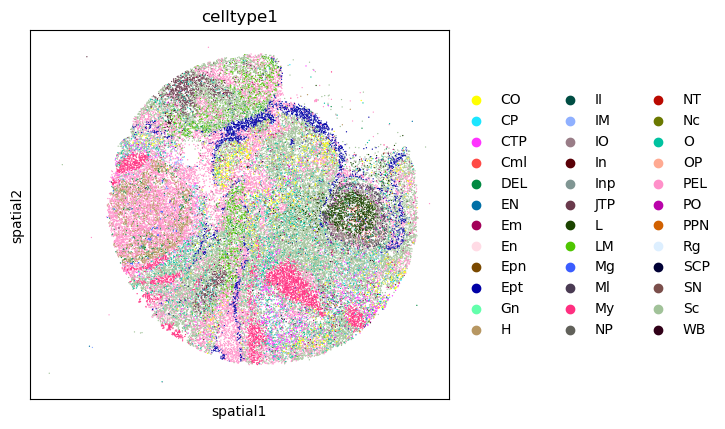

In [48]:
plt.figure(figsize=(5,20))
sc.pl.spatial(adata, color="celltype1", spot_size=20)

In [49]:
adata.write_h5ad(
    '/Users/hs0424/Workspace/copulacci/data/slide_seq_mouse_embryo/adata.h5ad'
)